# Setup

In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@9e7bff1258896368a48bfdc72a01c05f0974f68f
%pip install xlrd

In [0]:
%load_ext google.colab.data_table

In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
import sklearn

from datetime import timedelta, date

In [0]:
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

## Import modules with data and models

In [0]:
%%capture
!git clone -b munging-to-files https://github.com/oughtinc/ergo

In [0]:
import sys

sys.path.append('ergo/notebooks/el-paso/scripts')

In [0]:
import texas_data
import onlyasith
import krismoore
import brachbach

# Load questions

We'll load all questions from the [El Paso](https://pandemic.metaculus.com/questions/4161/el-paso-series-supporting-covid-19-response-planning-in-a-mid-sized-city/) series.

In [8]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

questions = metaculus.get_questions(cat="internal--el-paso")

# the most logical order for the questions
order = [4128, 4137, 4152, 4170, 4155, 4154, 4153, 4204, 4201, 4185]

questions.sort(key = lambda q: order.index(q.id))

ergo.MetaculusQuestion.to_dataframe(questions)

,id,title,resolve_time
0,4128,"When will El Paso County, Texas, experience it...",2020-12-31 23:01:00
1,4137,How many new infections will be reported in El...,2020-12-31 23:00:00
2,4152,What will the average number of reported daily...,2020-12-31 23:00:00
3,4170,What will the average number of reported daily...,2020-12-31 23:00:00
4,4155,What portion of in-hospital cases in El Paso C...,2020-12-31 23:00:00
5,4154,What portion of in-hospital patients with Covi...,2020-12-31 23:00:00
6,4153,What will the maximum number of in-hospital la...,2021-01-01 00:00:00
7,4204,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
8,4201,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
9,4185,What will the unemployment rate be in El Paso ...,2020-12-31 23:00:00


# Ergo extensions

We'll define some helper functions that might get moved into Ergo in the future.

In [0]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


# Memoization

memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()


# Associating functions with Metaculus questions

question_samplers = {}
question_function_names = {}
id_to_question = dict((q.id, q) for q in questions)

def question(question_id, community_weight=0):
    q = id_to_question[question_id]
    q.refresh_question()
    def decorator(func):
        @functools.wraps(func)
        @mem
        def sampler():
            if ergo.flip(community_weight):
                value = q.sample_community()
            else:
                value = func()
            tagged_value = value
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                tagged_value = int((value - START_DATE).days)
            ergo.tag(tagged_value, str(question_id))
            return value
        question_samplers[question_id] = sampler
        question_function_names[question_id] = func.__name__
        sampler.question_id = question_id
        return sampler
    return decorator

def summarize_question_samples(samples):
    print(samples)
    summary = samples.describe().transpose().round(2)
    print(summary)
    summary.index = question_names = [question_function_names[int(i)] for i in summary.index]
    display(summary)

# Plotting distributions on return values
def plot_question(question_fn, num_samples=200):
  def model():
      clear_mem()
      question_fn()

  samples = ergo.run(model, num_samples=num_samples)

  summarize_question_samples(samples)
  question_id = question_fn.question_id

  q = id_to_question[question_id]
  key = str(q.id)
  q_samples = samples[str(q.id)]

  if key == "4128": # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
      q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

  q.refresh_question() 
  print(q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9))

# External data (cases, estimates, models)

## Texas government cases data

In [10]:
el_paso_cases = texas_data.get_el_paso_data()

el_paso_cases

,Cases so far,New cases
2020-03-04,0,NaN
2020-03-05,0,0
2020-03-06,0,0
2020-03-09,0,0
2020-03-10,0,0
2020-03-11,0,0
2020-03-12,0,0
2020-03-13,0,0
2020-03-15,1,1
2020-03-16,1,0


## @onlyasith's cases model



Pulled [here](https://docs.google.com/spreadsheets/d/1L6pzFAEJ6MfnUwt-ea6tetKyvdi0YubnK_70SGm436c/edit#gid=1807978187)

In [11]:
projected_cases = onlyasith.get_onlyasith_results()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## @KrisMoore's compiled data

Pulled [here](https://docs.google.com/spreadsheets/d/1eGF9xYmDmvAkr-dCmd-N4efHzPyYEfVl0YmL9zBvH9Q/edit#gid=1694267458).

In [12]:
compiled_data = krismoore.get_krismoore_data()

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## @brachbach model (cases -> hospitalized)

In [0]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components

In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up Texas Government data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:
        try:
            # Look up projections from @onlyasith's model
            cases = projected_cases.loc[date, "New cases"]
            if np.isnan(cases):
                raise KeyError
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            # We're beyond the time range for data and model
            return 0

@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

# Build @brachbach regression model
hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, daily_infections)

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

@mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# El Paso questions


     4128
0      24
1      25
2      15
3      29
4      16
..    ...
195    27
196    25
197    20
198    25
199    21

[200 rows x 1 columns]
      count   mean    std   min   25%   50%   75%    max
4128  200.0  25.06  10.56  14.0  22.0  25.0  25.0  131.0


,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,25.06,10.56,14.0,22.0,25.0,25.0,131.0


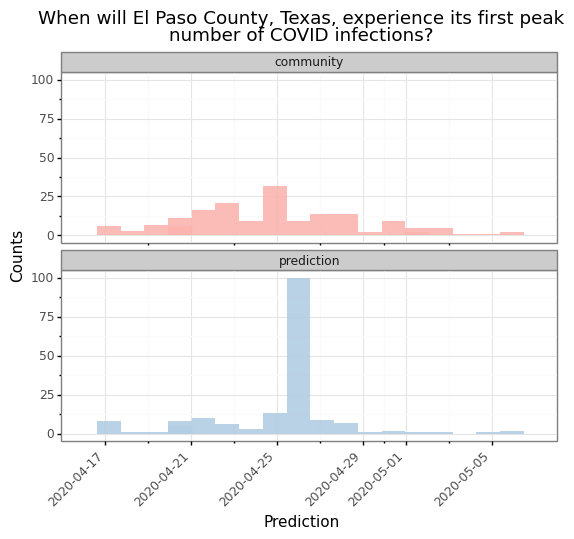

<ggplot: (8741748866964)>


In [15]:
@question(4128, community_weight=0.5)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    """    
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        yesterday = today - timedelta(1)
        tomorrow = today + timedelta(1)
        two_day_mean = mean_infections(yesterday, tomorrow)
        future_means = [mean_infections(today + timedelta(i), today + timedelta(i+2)) for i in range(10)]
        if two_day_mean > max(future_means):
            return today
    return end_date
plot_question(peak_infection_date)


     4128       4137
0    25.0  74.000000
1    21.0  47.000000
2    29.0  21.316534
3     NaN  42.766373
4    22.0  58.000000
..    ...        ...
195   NaN  48.396423
196   NaN  65.931114
197  27.0  27.000000
198   NaN  63.923813
199  25.0  74.000000

[200 rows x 2 columns]
      count    mean     std   min    25%   50%   75%      max
4128   98.0   25.30   11.19  14.0  23.25  25.0  25.0   102.00
4137  200.0  110.08  447.31   0.0  48.05  68.0  74.0  5345.35


,count,mean,std,min,25%,50%,75%,max
peak_infection_date,98.0,25.30,11.19,14.0,23.25,25.0,25.0,102.00
peak_infections,200.0,110.08,447.31,0.0,48.05,68.0,74.0,5345.35


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


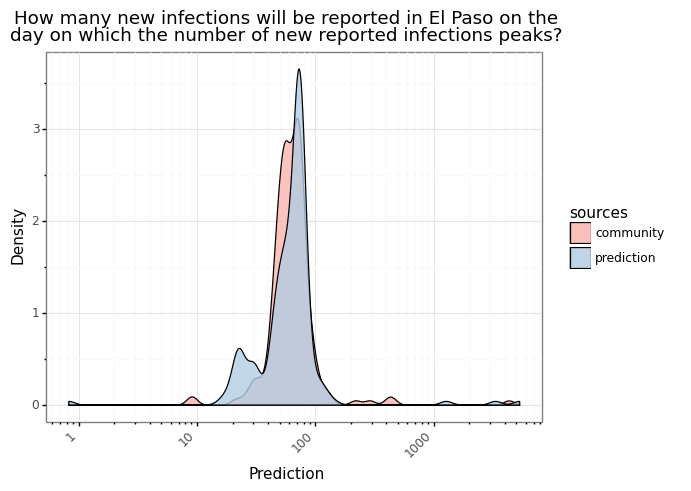

<ggplot: (8741745436052)>


In [16]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)


     4128         4152
0    25.0    23.563818
1     NaN    47.864426
2    29.0    13.322051
3     NaN    33.490543
4     NaN  1997.051880
..    ...          ...
195   NaN    22.798248
196  25.0    22.750406
197   NaN    24.756636
198  25.0    23.022896
199   NaN    74.283722

[200 rows x 2 columns]
      count   mean     std   min    25%    50%    75%      max
4128  109.0  25.39    7.61  15.0  24.00  25.00  25.00    77.00
4152  200.0  36.06  139.73   0.0  21.36  23.49  30.01  1997.05


,count,mean,std,min,25%,50%,75%,max
peak_infection_date,109.0,25.39,7.61,15.0,24.00,25.00,25.00,77.00
mean_infections_peak345,200.0,36.06,139.73,0.0,21.36,23.49,30.01,1997.05


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


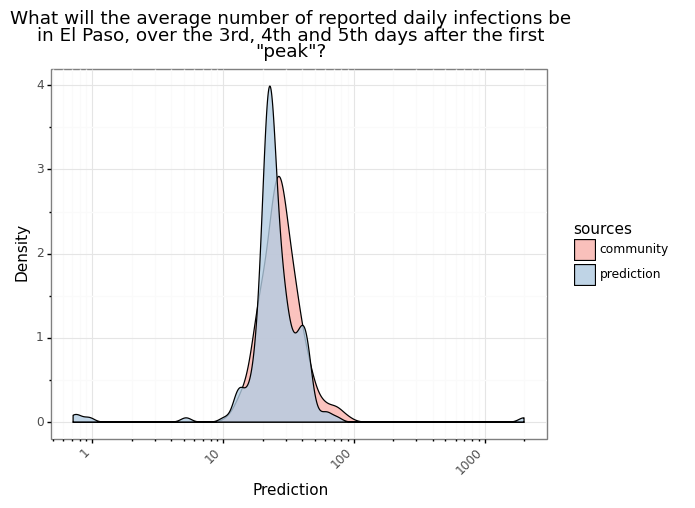

<ggplot: (-9223363295105907775)>


In [17]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)


            4170  4128
0      34.423279   NaN
1    2075.023682   NaN
2      20.994781   NaN
3      29.192545   NaN
4      26.154819   NaN
..           ...   ...
195    18.810101   NaN
196    11.161439   NaN
197    16.056726  25.0
198    25.446127   NaN
199    16.396112   NaN

[200 rows x 2 columns]
      count   mean     std    min    25%    50%    75%      max
4170  200.0  66.86  292.45  10.28  16.17  22.18  30.01  2627.43
4128   33.0  23.64    2.77  16.00  22.00  25.00  25.00    30.00


,count,mean,std,min,25%,50%,75%,max
mean_infections_peak678,200.0,66.86,292.45,10.28,16.17,22.18,30.01,2627.43
peak_infection_date,33.0,23.64,2.77,16.00,22.00,25.00,25.00,30.00


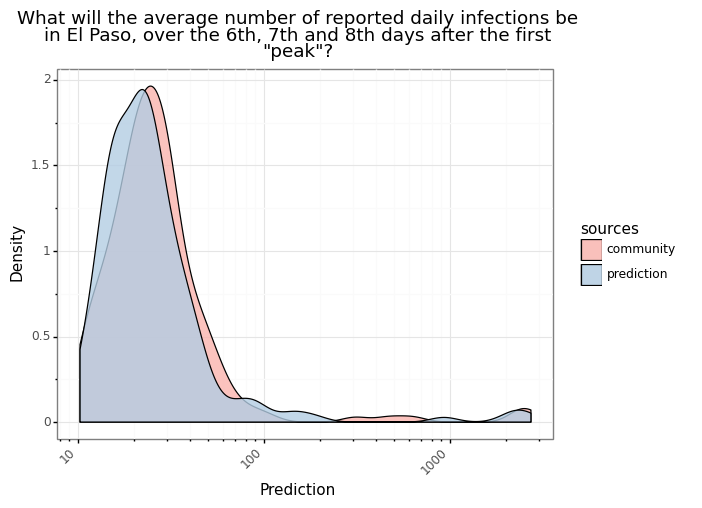

<ggplot: (-9223363295110226295)>


In [18]:

@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)


         4155
0    0.231833
1    0.144279
2    0.328358
3    0.248756
4    0.278607
..        ...
195  0.329254
196  0.179104
197  0.278607
198  0.407960
199  0.279805

[200 rows x 1 columns]
      count  mean  std   min   25%   50%   75%   max
4155  200.0   0.3  0.1  0.01  0.23  0.29  0.35  0.63


,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.3,0.1,0.01,0.23,0.29,0.35,0.63


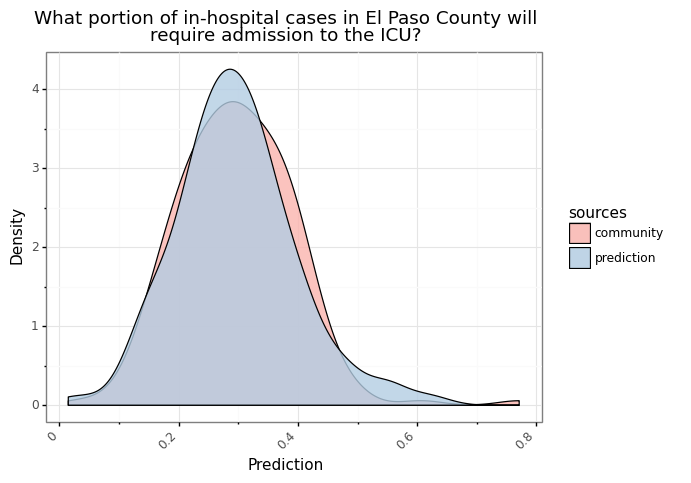

<ggplot: (8741744401791)>


In [19]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)


         4155      4154
0    0.582090  0.305620
1    0.402985  0.203758
2    0.348259  0.181393
3    0.275201  0.139681
4    0.398010  0.214723
..        ...       ...
195  0.467662  0.223239
196  0.228856  0.120532
197  0.353852  0.176964
198  0.402985  0.235217
199  0.592040  0.289919

[200 rows x 2 columns]
      count  mean   std   min   25%   50%   75%   max
4155  148.0  0.32  0.10  0.13  0.25  0.31  0.39  0.59
4154  200.0  0.16  0.06  0.03  0.12  0.15  0.20  0.31


,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,148.0,0.32,0.10,0.13,0.25,0.31,0.39,0.59
frac_patients_invasive,200.0,0.16,0.06,0.03,0.12,0.15,0.20,0.31


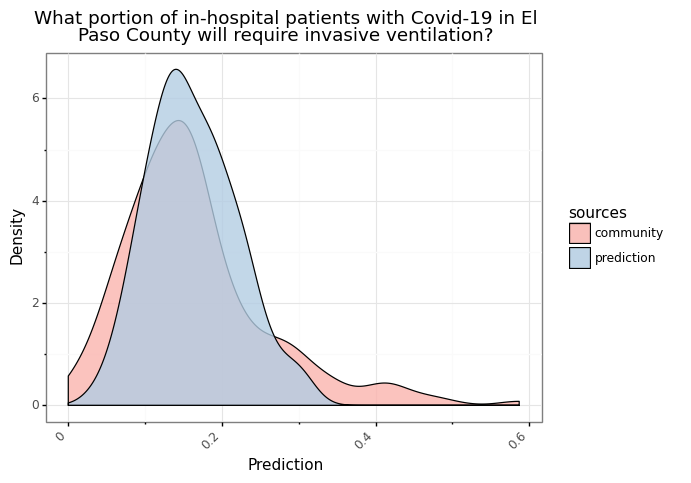

<ggplot: (8741744549510)>


In [20]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)


     4128       4153
0    25.0  65.000000
1    18.0  65.000000
2    25.0  65.000000
3    25.0  65.000000
4     NaN  69.194931
..    ...        ...
195   NaN  73.742455
196  25.0  71.049187
197  25.0  65.000000
198  25.0  69.538361
199  22.0  70.426659

[200 rows x 2 columns]
      count    mean      std    min   25%   50%    75%       max
4128  148.0   24.50     6.05  14.00  22.0  25.0  25.00     54.00
4153  200.0  194.46  1334.48  18.24  65.0  65.0  65.03  16341.69


,count,mean,std,min,25%,50%,75%,max
peak_infection_date,148.0,24.50,6.05,14.00,22.0,25.0,25.00,54.00
max_30d_hospital_confirmed_for_peak,200.0,194.46,1334.48,18.24,65.0,65.0,65.03,16341.69


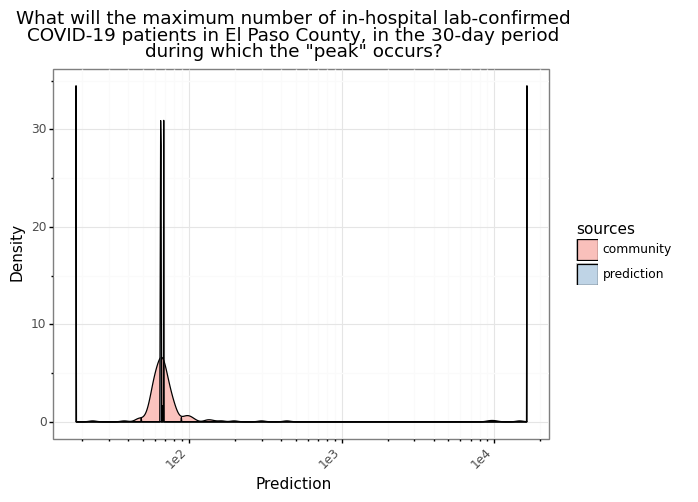

<ggplot: (8741742700857)>


In [21]:
@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = peak_infection_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(hospital_confirmed_for_date(day) for day in days)

plot_question(max_30d_hospital_confirmed_for_peak)


     4128       4153
0    53.0  18.704241
1    25.0  65.000000
2    14.0  65.000000
3    25.0  65.654945
4    25.0  65.000000
..    ...        ...
195  19.0  65.000000
196  32.0  63.831005
197  25.0  65.000000
198  25.0  65.000000
199  25.0  65.000000

[200 rows x 2 columns]
      count    mean      std    min   25%   50%   75%       max
4128  140.0   25.36    11.01  14.00  23.0  25.0  25.0    139.00
4153  200.0  197.06  1261.24   1.21  65.0  65.0  65.0  12708.27


,count,mean,std,min,25%,50%,75%,max
peak_infection_date,140.0,25.36,11.01,14.00,23.0,25.0,25.0,139.00
max_30d_hospital_confirmed_for_peak,200.0,197.06,1261.24,1.21,65.0,65.0,65.0,12708.27


/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in multiply
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)


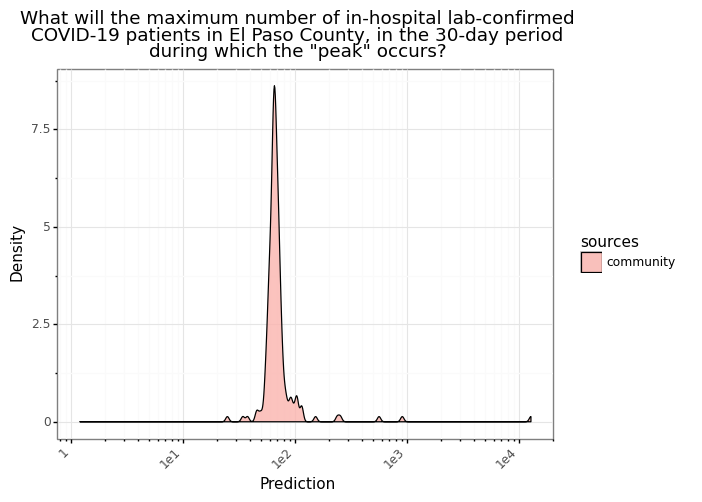

<ggplot: (8741744593023)>


In [28]:
@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4204/

    Alternative:    
    - peak = peak_hospitalizations_date()
    - return daily_icu_admissions(peak)

    FIXME: Admissions vs in-hospital patients unclear

    Not mixing in community since this is just the product of two other questions.    
    """
    max_patients = max_30d_hospital_confirmed_for_peak()
    return max_patients * frac_patients_icu()
plot_question(max_30d_hospital_confirmed_for_peak)


          4153      4155       4204       4201   4128
0    67.027435  0.258706  17.340431   8.473913    NaN
1    65.000000  0.149254   9.701492   4.963954   25.0
2    66.520287  0.477612  31.770882  17.205483   40.0
3    65.000000  0.388060  25.223881  12.903457   25.0
4    65.000000  0.293532  19.079601   9.660888   25.0
..         ...       ...        ...        ...    ...
195  65.814651  0.303483  19.973601  11.387976   25.0
196  57.166866  0.203980  11.660903   5.529304    NaN
197   1.253949  0.348259   0.436699   0.204018  104.0
198  65.000000  0.261784  17.015987   8.355937   25.0
199  70.081612  0.254009  17.801352   8.239316   24.0

[200 rows x 5 columns]
      count   mean    std    min    25%    50%    75%     max
4153  200.0  67.04  22.26   1.21  65.00  65.00  65.00  247.14
4155  200.0   0.30   0.09   0.06   0.25   0.30   0.36    0.59
4204  200.0  20.54  10.35   0.31  15.85  19.25  24.25   99.88
4201  200.0  10.52   5.40   0.15   8.01   9.71  12.32   51.15
4128  145.0  25.5

,count,mean,std,min,25%,50%,75%,max
max_30d_hospital_confirmed_for_peak,200.0,67.04,22.26,1.21,65.00,65.00,65.00,247.14
frac_patients_icu,200.0,0.30,0.09,0.06,0.25,0.30,0.36,0.59
peak_icu_admissions,200.0,20.54,10.35,0.31,15.85,19.25,24.25,99.88
peak_invasive_ventilation,200.0,10.52,5.40,0.15,8.01,9.71,12.32,51.15
peak_infection_date,145.0,25.57,12.60,14.00,22.00,25.00,25.00,133.00


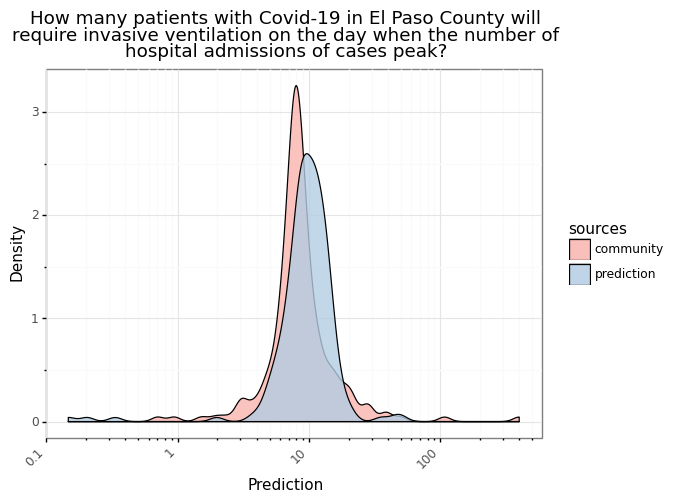

<ggplot: (8741742655892)>


In [23]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4201/#comment-28004

    Not mixing in community since this is just the product of two other questions.
    """
    return frac_icu_ventilation() * peak_icu_admissions()

plot_question(peak_invasive_ventilation)

# Generate predictions for all questions

In [24]:
def model():
    clear_mem()
    for question_sampler in question_samplers.values():
        question_sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)


      4128       4137       4152  ...       4153       4204       4201
0       25  89.818863  24.990454  ...  65.000000  17.070831   8.755158
1       25  74.000000  30.841255  ...  59.015491   1.761656   0.860495
2       25  65.931114  14.689962  ...  65.760284  18.975604   9.235403
3       26  28.611603  22.128700  ...  65.000000  17.462688   7.974029
4       25  68.001434  21.695457  ...  67.027435  26.010647  13.154916
...    ...        ...        ...  ...        ...        ...        ...
1995    25  74.000000  22.604185  ...  65.000000  16.815922   7.051981
1996    24  56.487427  20.425905  ...  86.462097  21.507984  11.059342
1997    17  31.000000  38.000000  ...  65.000000  32.338306  16.648722
1998    25  60.090694  11.161439  ...  65.000000  14.599370   6.952429
1999    25  74.000000  24.085829  ...  65.000000  15.522388   7.380675

[2000 rows x 9 columns]
       count    mean     std    min    25%    50%    75%       max
4128  2000.0   25.88   12.30  14.00  24.00  25.00  25.0

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,2000.0,25.88,12.30,14.00,24.00,25.00,25.00,141.00
peak_infections,2000.0,90.79,386.12,0.00,47.00,63.92,74.00,6355.15
mean_infections_peak345,2000.0,39.06,176.36,0.00,20.99,23.89,30.01,3088.22
mean_infections_peak678,2000.0,49.64,251.66,0.00,15.95,22.06,30.84,4876.29
frac_patients_icu,2000.0,0.29,0.10,0.01,0.23,0.29,0.35,0.90
frac_patients_invasive,2000.0,0.15,0.07,0.00,0.11,0.15,0.19,0.65
max_30d_hospital_confirmed_for_peak,2000.0,105.21,707.23,1.16,65.00,65.00,65.00,14945.42
peak_icu_admissions,2000.0,28.95,187.42,0.20,14.77,19.07,23.67,5035.17
peak_invasive_ventilation,2000.0,14.83,96.82,0.10,7.51,9.65,12.05,2617.57


# Compare predictions to community

This takes a while since we're fitting a mixture of logistic distributions to our samples before visualizing (and submitting) them.
These may look a little different from the plots below the questions above, because we've taken more samples from the distribution and we're fitting logistic distributions so we can submit them to metaculus

4128


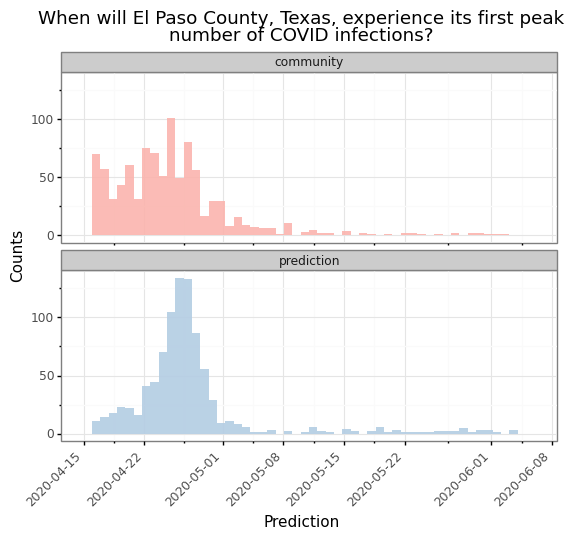

<ggplot: (8741745449669)>
4137


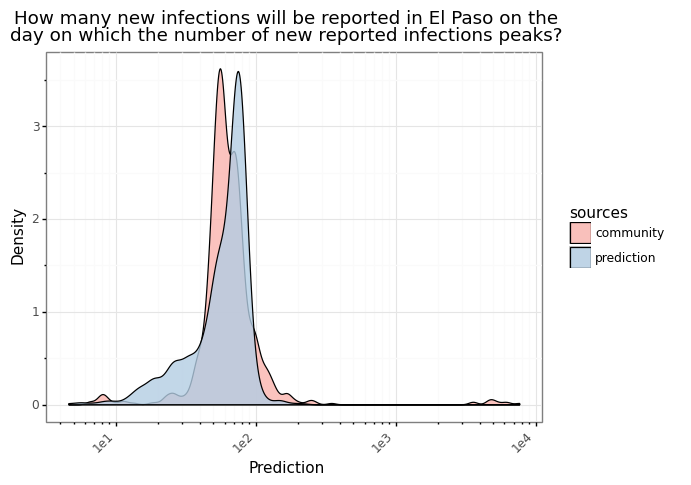

<ggplot: (-9223363295106609902)>
4152


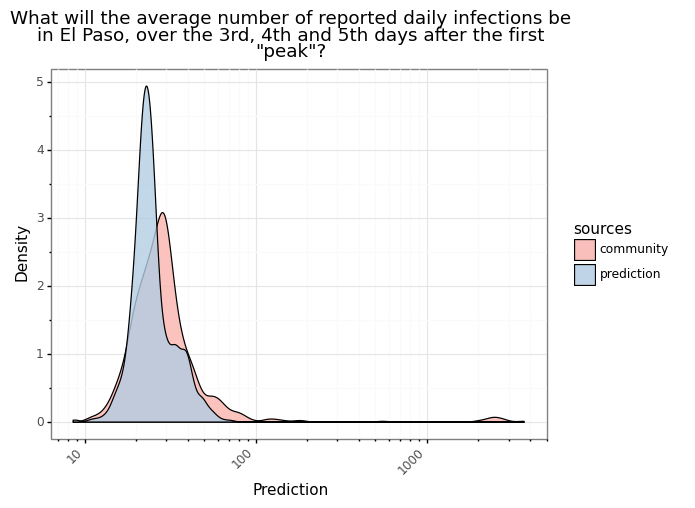

<ggplot: (8741749089649)>
4170


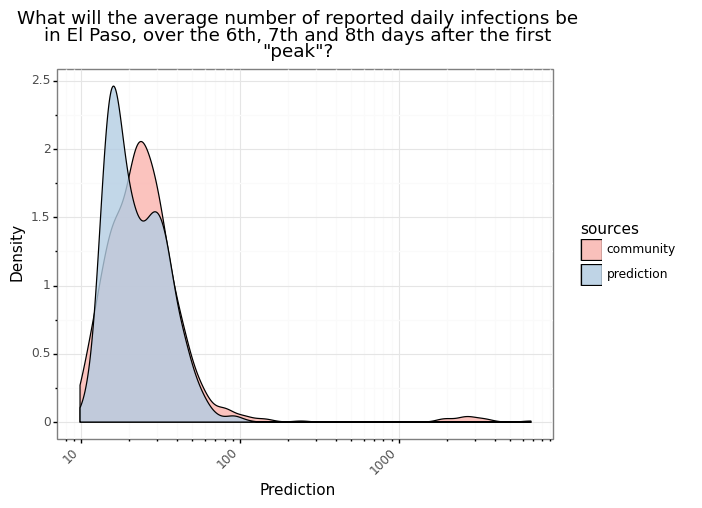

<ggplot: (-9223363295112074829)>
4155


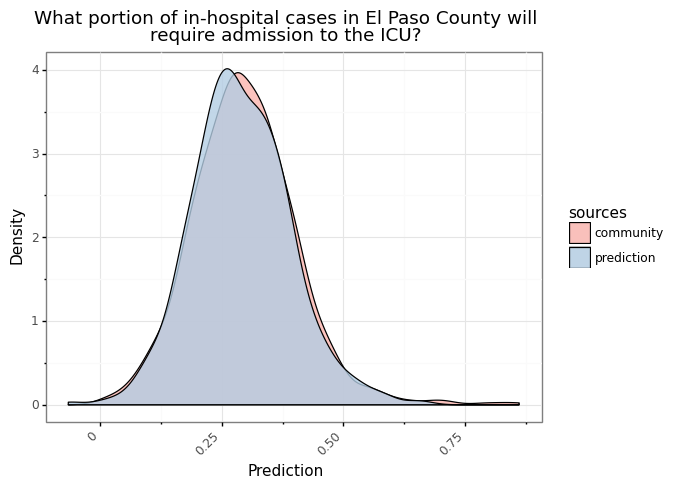

<ggplot: (8741732370359)>
4154


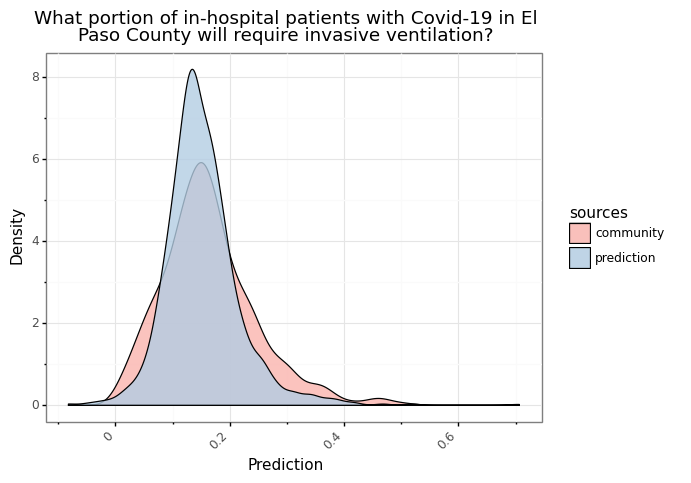

<ggplot: (-9223363295110366667)>
4153


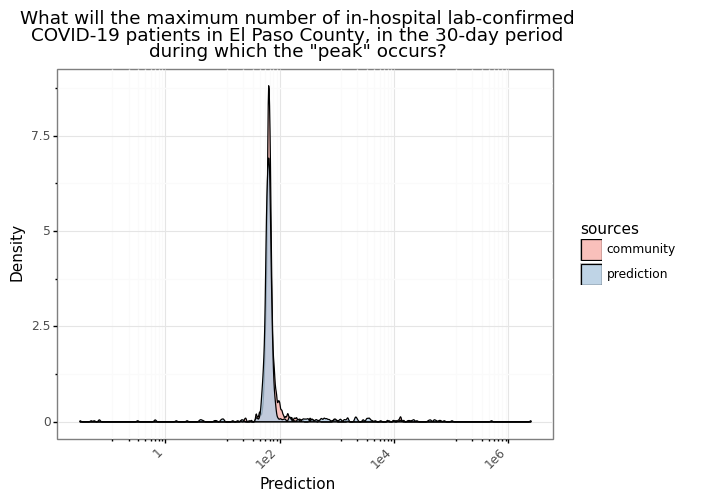

<ggplot: (-9223363295122339356)>
4204


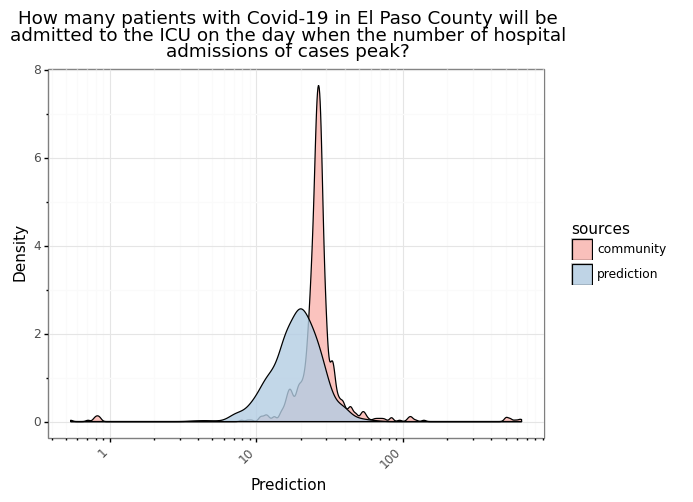

<ggplot: (8741732135393)>
4201


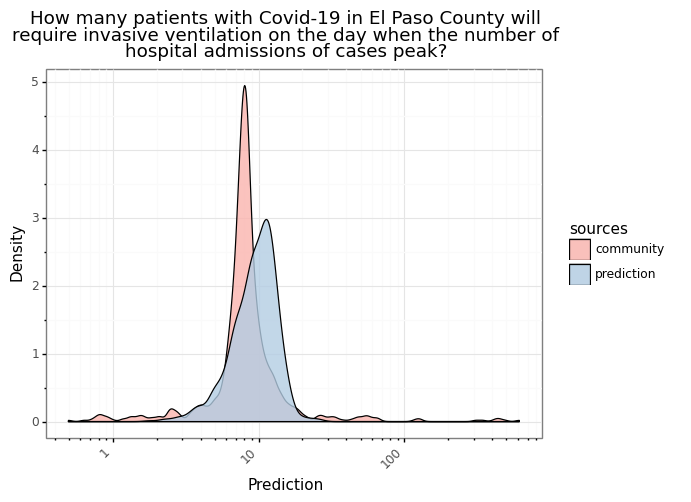

<ggplot: (8741742755634)>
4185


In [25]:
submissions = {}
for q in questions:
    print(q.id)
    if q.id == 4185: # We didn't predict the unemployment question
        continue

    key = str(q.id)
    q_samples = samples[str(q.id)]

    if key == "4128": # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])
    
    q.refresh_question()

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
      # Clip extreme values for questions that we had issues fitting
      (sample_min, sample_max) = np.quantile(q_samples, [0.02, 0.98])
      q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission
    print(q.show_prediction(samples=submission, show_community=True, percent_kept=0.9))

In [0]:
# Should we submit this to Metaculus? If so, uncomment the following line:
# for q, submission in submissions.items():  
#     q.submit(submission)